# Data Cleaning
Author Brian Tam, 10/16/2020

This notebook is used to clean the [MBTI kaggle dataset](https://www.kaggle.com/datasnaek/mbti-type) as an intermediate setup to prep it for moding.
The following was done:
1. Splitting the string of posts into individual posts
2. Exploding our dataframe rows so that each row consists of **one** tweet
3. Prepping the words for NLP by:
    - Tokenizing with sklearn and spaCy
    - Lemmatisation
    - Count vectorizing words
    - Topic modeling

In [3]:
# Get pandas and postgres to work together
import psycopg2 as pg
import pandas as pd
import numpy as np

# Import spacy and textblob to do NLP
import spacy
from textblob import TextBlob

# Import sklearn to do CountVectorizing
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

import matplotlib.pyplot as plt

import databricks.koalas as ks

# Topic Modeling
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

import re

In [27]:
# Postgres info to connect
connection_args = {
    'host': 'localhost',  # We are connecting to our _local_ version of psql
    'dbname': 'myers_briggs',    # DB that we are connecting to
}

connection = pg.connect(**connection_args)  # What is that "**" there??

In [28]:
query = "SELECT * FROM twitter_origin;"

df = pd.read_sql(query, connection)
df

type                                              posts
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1     ENTP  'I'm finding the lack of me in these posts ver...
2     INTP  'Good one  _____   https://www.youtube.com/wat...
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...
4     ENTJ  'You're fired.|||That's another silly misconce...
...    ...                                                ...
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...
8671  ENFP  'So...if this thread already exists someplace ...
8672  INTP  'So many questions when i do these things.  I ...
8673  INFP  'I am very conflicted right now when it comes ...
8674  INFP  'It has been too long since I have been on per...

[8675 rows x 2 columns]

# Multiclass to binary classification
Since it'll be easier to do binary classification, I create boolians for each Letter pair

In [29]:
map1 = {"I": 0, "E": 1}
map2 = {"S": 0, "N": 1}
map3 = {"T": 0, "F": 1}
map4 = {"J": 0, "P": 1}
df['I-E'] = df['type'].astype(str).str[0]
df['I-E'] = df['I-E'].map(map1)
df['N-S'] = df['type'].astype(str).str[1]
df['N-S'] = df['N-S'].map(map2)
df['T-F'] = df['type'].astype(str).str[2]
df['T-F'] = df['T-F'].map(map3)
df['J-P'] = df['type'].astype(str).str[3]
df['J-P'] = df['J-P'].map(map4)
print(df.head(10))

   type                                              posts  I-E  N-S  T-F  J-P
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...    0    1    1    0
1  ENTP  'I'm finding the lack of me in these posts ver...    1    1    0    1
2  INTP  'Good one  _____   https://www.youtube.com/wat...    0    1    0    1
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...    0    1    0    0
4  ENTJ  'You're fired.|||That's another silly misconce...    1    1    0    0
5  INTJ  '18/37 @.@|||Science  is not perfect. No scien...    0    1    0    0
6  INFJ  'No, I can't draw on my own nails (haha). Thos...    0    1    1    0
7  INTJ  'I tend to build up a collection of things on ...    0    1    0    0
8  INFJ  I'm not sure, that's a good question. The dist...    0    1    1    0
9  INTP  'https://www.youtube.com/watch?v=w8-egj0y8Qs||...    0    1    0    1


In [30]:
df

type                                              posts  I-E  N-S  T-F  \
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...    0    1    1   
1     ENTP  'I'm finding the lack of me in these posts ver...    1    1    0   
2     INTP  'Good one  _____   https://www.youtube.com/wat...    0    1    0   
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...    0    1    0   
4     ENTJ  'You're fired.|||That's another silly misconce...    1    1    0   
...    ...                                                ...  ...  ...  ...   
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...    0    0    1   
8671  ENFP  'So...if this thread already exists someplace ...    1    1    1   
8672  INTP  'So many questions when i do these things.  I ...    0    1    0   
8673  INFP  'I am very conflicted right now when it comes ...    0    1    1   
8674  INFP  'It has been too long since I have been on per...    0    1    1   

      J-P  
0       0  
1       1  
2       1  
3       0  
4       0  
...   ...  
8670    1  
8671    1  
8672    1  
8673    1  
8674    1  

[8675 rows x 6 columns]

# Split posts
One post per row

In [31]:
df['post'] = df.apply(lambda row: row.posts.split('|||'), axis = 1) 

In [32]:
def quoteRemover(x):
    """
    Removes the annoying single quote sign at the beginning and end of all the post chains.

    """
    if re.match("'",x[0]):
        x[0] = x[0][1:]
    if re.match("'",x[-1][::-1]):
        x[-1] = x[-1][:-1]
    

df['post'].apply(quoteRemover)

0       None
1       None
2       None
3       None
4       None
        ... 
8670    None
8671    None
8672    None
8673    None
8674    None
Name: post, Length: 8675, dtype: object

In [33]:
df = df.drop(['posts'],axis=1)

import utility that allows me to **explode** my posts into a seperate row each

In [34]:
from utilities.explode_posts import explode
df = explode(df, ['post'], fill_value='')

In [35]:
links_df = df[['http' in post for post in df['post']]]
links_df.head()

I-E  J-P  N-S  T-F  type                                               post
0    0    0    1    1  INFJ         http://www.youtube.com/watch?v=qsXHcwe3krw
1    0    0    1    1  INFJ  http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2    0    0    1    1  INFJ  enfp and intj moments  https://www.youtube.com...
4    0    0    1    1  INFJ  http://www.youtube.com/watch?v=vXZeYwwRDw8   h...
6    0    0    1    1  INFJ  The last thing my INFJ friend posted on his fa...

In [36]:
df.drop(df[['http' in post for post in df['post']]].index, inplace = True)

In [37]:
df['post'] = df.post.apply(lambda x: x.replace(',', ''))

In [38]:
df.post[7]

"Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth as..."

In [39]:
df['tweet_length'] = df['post'].apply(lambda x: len(x))
df.head()

I-E  J-P  N-S  T-F  type  \
3     0    0    1    1  INFJ   
5     0    0    1    1  INFJ   
7     0    0    1    1  INFJ   
9     0    0    1    1  INFJ   
11    0    0    1    1  INFJ   

                                                 post  tweet_length  
3   What has been the most life-changing experienc...            61  
5                May the PerC Experience immerse you.            36  
7   Hello ENFJ7. Sorry to hear of your distress. I...           199  
9                                  Welcome and stuff.            18  
11  Prozac wellbrutin at least thirty minutes of m...           198

In [40]:
#Source: https://www.careerplanner.com/MB2/TypeInPopulation.cfm

mbtipopdict = {'ISFJ':13.8, 'ESFJ':12.3, 'ISTJ':11.6, 'ISFP':8.8, 'ESTJ':8.7,'ESFP':8.5,'ENFP':8.1,'ISTP':5.4,'INFP':4.4,
              'ESTP':4.3,'INTP':3.3,'ENTP':3.2,'ENFJ':2.5,'INTJ':2.1,'ENTJ':1.8,'INFJ':1.5}
mbtipopdf = pd.DataFrame(data=mbtipopdict.values(), index=mbtipopdict.keys(), columns=['percentage'])
mbtipopdf.sort_values('percentage', ascending=False)

percentage
ISFJ        13.8
ESFJ        12.3
ISTJ        11.6
ISFP         8.8
ESTJ         8.7
ESFP         8.5
ENFP         8.1
ISTP         5.4
INFP         4.4
ESTP         4.3
INTP         3.3
ENTP         3.2
ENFJ         2.5
INTJ         2.1
ENTJ         1.8
INFJ         1.5

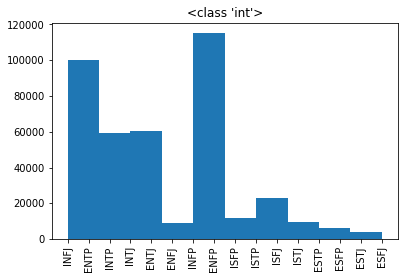

In [41]:
df.type.hist(type)

In [42]:
df.post[3]

'What has been the most life-changing experience in your life?'

# NLP

In [43]:
# While most reviewers leave a 5 star review, there are also a good portion leaving 1 star reviews
df.type.value_counts(normalize=True)

INFP    0.210682
INFJ    0.170505
INTP    0.149019
INTJ    0.124410
ENTP    0.081204
ENFP    0.078649
ISTP    0.038625
ISFP    0.030072
ENTJ    0.026981
ISTJ    0.023473
ENFJ    0.022180
ISFJ    0.019094
ESTP    0.010291
ESFP    0.005254
ESFJ    0.004957
ESTJ    0.004605
Name: type, dtype: float64

In [44]:
df

I-E  J-P  N-S  T-F  type  \
3         0    0    1    1  INFJ   
5         0    0    1    1  INFJ   
7         0    0    1    1  INFJ   
9         0    0    1    1  INFJ   
11        0    0    1    1  INFJ   
...     ...  ...  ...  ...   ...   
422840    0    1    1    1  INFP   
422841    0    1    1    1  INFP   
422842    0    1    1    1  INFP   
422843    0    1    1    1  INFP   
422844    0    1    1    1  INFP   

                                                     post  tweet_length  
3       What has been the most life-changing experienc...            61  
5                    May the PerC Experience immerse you.            36  
7       Hello ENFJ7. Sorry to hear of your distress. I...           199  
9                                      Welcome and stuff.            18  
11      Prozac wellbrutin at least thirty minutes of m...           198  
...                                                   ...           ...  
422840  I was going to close my facebook a few months ...           192  
422841  30 Seconds to Mars - All of my collections. It...            85  
422842  I have seen it and i agree. I did actually thi...           197  
422843  Ok so i have just watched Underworld 4 (Awaken...           199  
422844  I would never want to turn off my emotions. so...           110  

[397614 rows x 7 columns]

In [45]:
# Text preprocessing steps - remove numbers, captial letters and punctuation
import re
import string

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

df['post'] = df.post.map(alphanumeric).map(punc_lower)
df

I-E  J-P  N-S  T-F  type  \
3         0    0    1    1  INFJ   
5         0    0    1    1  INFJ   
7         0    0    1    1  INFJ   
9         0    0    1    1  INFJ   
11        0    0    1    1  INFJ   
...     ...  ...  ...  ...   ...   
422840    0    1    1    1  INFP   
422841    0    1    1    1  INFP   
422842    0    1    1    1  INFP   
422843    0    1    1    1  INFP   
422844    0    1    1    1  INFP   

                                                     post  tweet_length  
3       what has been the most life changing experienc...            61  
5                    may the perc experience immerse you             36  
7       hello    sorry to hear of your distress  it s ...           199  
9                                      welcome and stuff             18  
11      prozac wellbrutin at least thirty minutes of m...           198  
...                                                   ...           ...  
422840  i was going to close my facebook a few months ...           192  
422841    seconds to mars   all of my collections  it ...            85  
422842  i have seen it and i agree  i did actually thi...           197  
422843  ok so i have just watched underworld    awaken...           199  
422844  i would never want to turn off my emotions  so...           110  

[397614 rows x 7 columns]

# Train Test Split

In [46]:
# Split the data into X and y data sets
X = df.post
y = df['I-E']

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Word2vec

In [47]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [49]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['post'])

In [53]:

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]


# Practice with spaCy

In [25]:
# Create our list of punctuation marks
punctuations = string.punctuation
# Create our list of stopwords
spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
# Load English tokenizer, tagger, parser, NER and word vectors
parser = EN()
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    # return preprocessed list of tokens
    return mytokens

NameError: name 'EN' is not defined

In [22]:
X_train

NameError: name 'X_train' is not defined

In [ ]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import accuracy_score 
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

import string
punctuations = string.punctuation

from spacy.lang.en import English
parser = English()

#Custom transformer using spaCy 
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# Basic utility function to clean the text 
def clean_text(text):     
    return text.strip().lower()

In [45]:
#Create spacy tokenizer that parses a sentence and generates tokens
#these can also be replaced by word vectors 
def spacy_tokenizer(sentence):
    tokens = parser(sentence)
    tokens = [tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_ for tok in tokens]
    tokens = [tok for tok in tokens if (tok not in stopwords and tok not in punctuations)]     
    return tokens
    

#create vectorizer object to generate feature vectors, we will use custom spacy’s tokenizer
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
classifier = LinearSVC()

In [ ]:
# Create the  pipeline to clean, tokenize, vectorize, and classify 
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', classifier)])

# Load sample data
train = list(zip(X_train,y_train))
test =  list(zip(X_test,y_test))

# Create model and measure accuracy
pipe.fit([x[0] for x in train], [x[1] for x in train]) 
pred_data = pipe.predict([x[0] for x in test]) 
for (sample, pred) in zip(test, pred_data):
    print(sample, pred)
print("Accuracy:", accuracy_score([x[1] for x in test], pred_data))
print("Accuracy:", accuracy_score([x[1] for x in test], pred_data))
print("Accuracy:", accuracy_score([x[1] for x in test], pred_data))

/Users/briantam/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


('sleepyfox i m crying  ahahah', 0) 0
('i d say xnfj  clear n  i d go with f over t but there s some t in there    fe    thanking everyone all the time    don t speak for yourself speak for the group ', 0) 0
('hi and welcome glad to see a new addition i hope you hang around and enjoy you will find there are some really interesting and great people here and so much to learn  laughing ', 0) 0
('never too late  i m   and in   year of mba  my classmates  age ranges from        about    of them are sponsored by their companies  the rest either want advancement in their fields or switch   ', 0) 0
('not to steal your words   but that is exactly what i came here to say   happy  i have a strong artistic opinion and like things to be pretty well arranged and complementary and i think people pick   ', 1) 0
('i am defiantly not a feeler my infp mother would laugh at that  i think it all depends on the environment your brought up in or how you are raised maybe even experiences that we go through ',

In [36]:
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer(min_df=5, max_features=2000, stop_words='english')

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()

ability  able  absolute  absolutely  abstract  accept  accepted  accepting  \
0        0     0         0           0         0       0         0          0   
1        0     0         0           0         0       0         0          0   
2        0     0         0           1         0       0         0          0   
3        0     0         0           0         0       0         0          0   
4        0     0         0           0         0       0         0          0   

   according  account  ...  year  years  yep  yes  yesterday  young  younger  \
0          0        0  ...     0      0    0    0          0      0        0   
1          0        0  ...     0      0    0    0          0      0        0   
2          0        0  ...     0      0    0    0          0      0        0   
3          0        0  ...     0      0    0    0          0      0        0   
4          0        0  ...     0      0    0    0          0      0        0   

   youtube  yup  zone  
0        0    0     0  
1        0    0     0  
2        0    0     0  
3        0    0     0  
4        0    0     0  

[5 rows x 2000 columns]

In [80]:
X_train_cv1

<278329x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 1960521 stored elements in Compressed Sparse Row format>

In [79]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(min_df=5, max_features=1000, ngram_range=(1,2), binary=True, stop_words='english')

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()

10  100  12  15  16  20  30  50  ability  able  ...  yeah  year  years  \
0   0    0   0   0   0   0   0   0        0     0  ...     0     0      0   
1   0    0   0   0   0   0   0   0        0     0  ...     0     0      0   
2   0    0   0   0   0   0   0   0        0     0  ...     0     0      0   
3   0    0   0   0   0   0   0   0        0     0  ...     0     0      0   
4   0    0   0   0   0   0   0   0        0     0  ...     0     0      0   

   years ago  yep  yes  yesterday  young  younger  youtube  
0          0    0    0          0      0        0        0  
1          0    0    0          0      0        0        0  
2          0    0    0          0      0        0        0  
3          0    0    0          0      0        0        0  
4          0    0    0          0      0        0        0  

[5 rows x 1000 columns]

In [45]:
X_train_cv2.columns

AttributeError: columns not found

### Try classifying using Logistic Regression

In [30]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight = 'balanced')

In [31]:
# Train the first model
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

In [32]:
# Train the second model
lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

NameError: name 'X_train_cv2' is not defined

In [33]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

In [34]:
df['I-E'].value_counts()

0    304524
1     93090
Name: I-E, dtype: int64

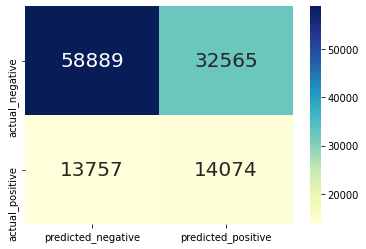

In [35]:
# The heat map for the first logistic regression model
cm1 = conf_matrix(y_test, y_pred_cv1)

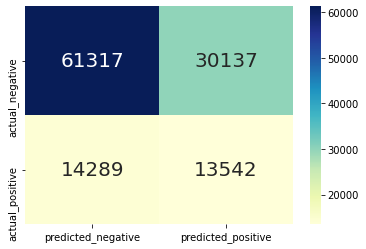

In [59]:
# The heat map for the second logistic regression model
cm2 = conf_matrix(y_test, y_pred_cv2)

In [60]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1', 'LogReg2']
results

LogReg1  LogReg2
Accuracy     0.623    0.628
Precision    0.307    0.310
Recall       0.489    0.487
F1 Score     0.377    0.379

### Try classifying using Naive Bayes

In [39]:
# Fit the first Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train_cv1, y_train)

y_pred_cv1_nb = mnb.predict(X_test_cv1)

In [40]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train_cv2, y_train)

y_pred_cv2_nb = bnb.predict(X_test_cv2)

NameError: name 'X_train_cv2' is not defined

In [41]:
print(y_test.shape)
y_pred_cv1_nb.shape

(119285,)


(119285,)

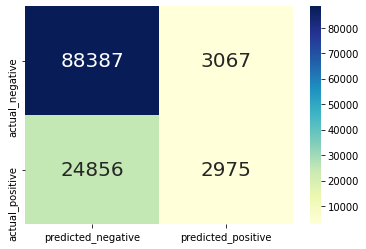

In [42]:
# Here's the heat map for the first Naive Bayes model
cm3 = conf_matrix(y_test, y_pred_cv1_nb)

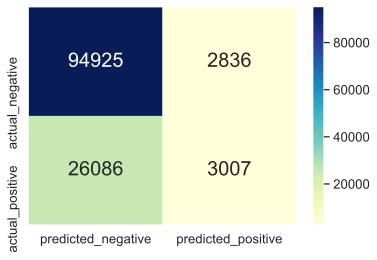

In [271]:
# Here's the heat map for the second Naive Bayes model
cm4 = conf_matrix(y_test, y_pred_cv2_nb)

In [272]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm3, cm4)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['NB1', 'NB2']
results_nb

results = pd.concat([results, results_nb], axis=1)
results

NameError: name 'results' is not defined

### Try using TF-IDF instead of Count Vectorizer

In [103]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(stop_words='english')
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english')
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

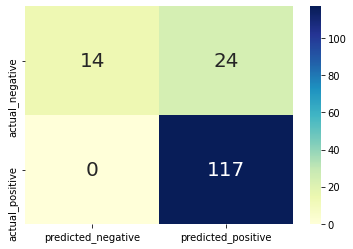

In [37]:
# Fit the first logistic regression on the TF-IDF data
lr.fit(X_train_tfidf1, y_train)
y_pred_tfidf1_lr = lr.predict(X_test_tfidf1)
cm5 = conf_matrix(y_test, y_pred_tfidf1_lr)

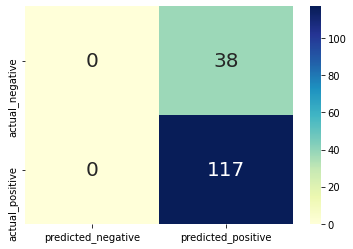

In [38]:
# Fit the second logistic regression on the TF-IDF data
lr.fit(X_train_tfidf2, y_train)
y_pred_tfidf2_lr = lr.predict(X_test_tfidf2)
cm6 = conf_matrix(y_test, y_pred_tfidf2_lr)

# topic modeling

In [81]:
# Acronynms: Latent Semantic Analysis (LSA) is just another name for 
#  Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
lsa = TruncatedSVD(2)
doc_topic = lsa.fit_transform(pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()))
lsa.explained_variance_ratio_

array([0.02268705, 0.0204498 ])

# Appendix

In [11]:
d6tstack.utils.pd_to_psql?

Signature:
d6tstack.utils.pd_to_psql(
    df,
    uri,
    table_name,
    schema_name=None,
    if_exists='fail',
    sep=',',
)
Docstring:
Load pandas dataframe into a sql table using native postgres COPY FROM.

Args:
    df (dataframe): pandas dataframe
    uri (str): postgres psycopg2 sqlalchemy database uri
    table_name (str): table to store data in
    schema_name (str): name of schema in db to write to
    if_exists (str): {‘fail’, ‘replace’, ‘append’}, default ‘fail’. See `pandas.to_sql()` for details
    sep (str): separator for temp file, eg ',' or ' '

Returns:
    bool: True if loader finished
File:      ~/opt/anaconda3/envs/metis/lib/python3.8/site-packages/d6tstack/utils.py
Type:      function


In [149]:
import d6tstack

# fast CSV to SQL import - see SQL examples notebook
d6tstack.utils.pd_to_psql(df, 'postgresql+psycopg2://briantam: @localhost/myers_briggs', 'twitter', if_exists='replace')

True

In [ ]:
# Create our list of punctuation marks
punctuations = df.post[3].punctuation
# Create our list of stopwords
spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
# Load English tokenizer, tagger, parser, NER and word vectors
parser = EN()
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    # return preprocessed list of tokens
    return mytokens